Seneth Waterman,
Cassie Richter,
Nick Miller,
Caleb Hamblen


link to medium post: https://medium.com/@cjrichter_71745/murabones-using-cnn-to-detect-abnormalities-in-musculoskeletal-x-rays-7affdedcc20d

link to github repo: https://github.com/cjrich19/MURABONES_DLproject

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/MURA-v1.1.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: /content/MURA-v1.1/train/XR_SHOU

### 1. Load Data and Split into Train/Val/Test Sets

In [ ]:
def create_data_frame(filepath):
    df = pd.read_csv(filepath, names=['file_path', 'label'])
    df['body_part'] = df.apply(lambda x: x.file_path.split('/')[2][3:],axis=1)
    df['patient_id'] = df.apply(lambda x: x.file_path.split('/')[3][7:],axis=1)
    df['study_type'] = df.apply(lambda x: x.file_path.split('/')[4][:6],axis=1)
    return df

In [ ]:
train_file_path = '/content/MURA-v1.1/train_labeled_studies.csv'
test_file_path = '/content/MURA-v1.1/valid_labeled_studies.csv'  # Because we do not have access to testing data, so use Val as Test
train_df = create_data_frame(train_file_path)
test_data = create_data_frame(test_file_path)

In [ ]:
# Split training set into train/val - keep patients together
groups = train_df['patient_id']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(train_df, groups=groups))

train_data = train_df.iloc[train_idx]
val_data = train_df.iloc[val_idx]

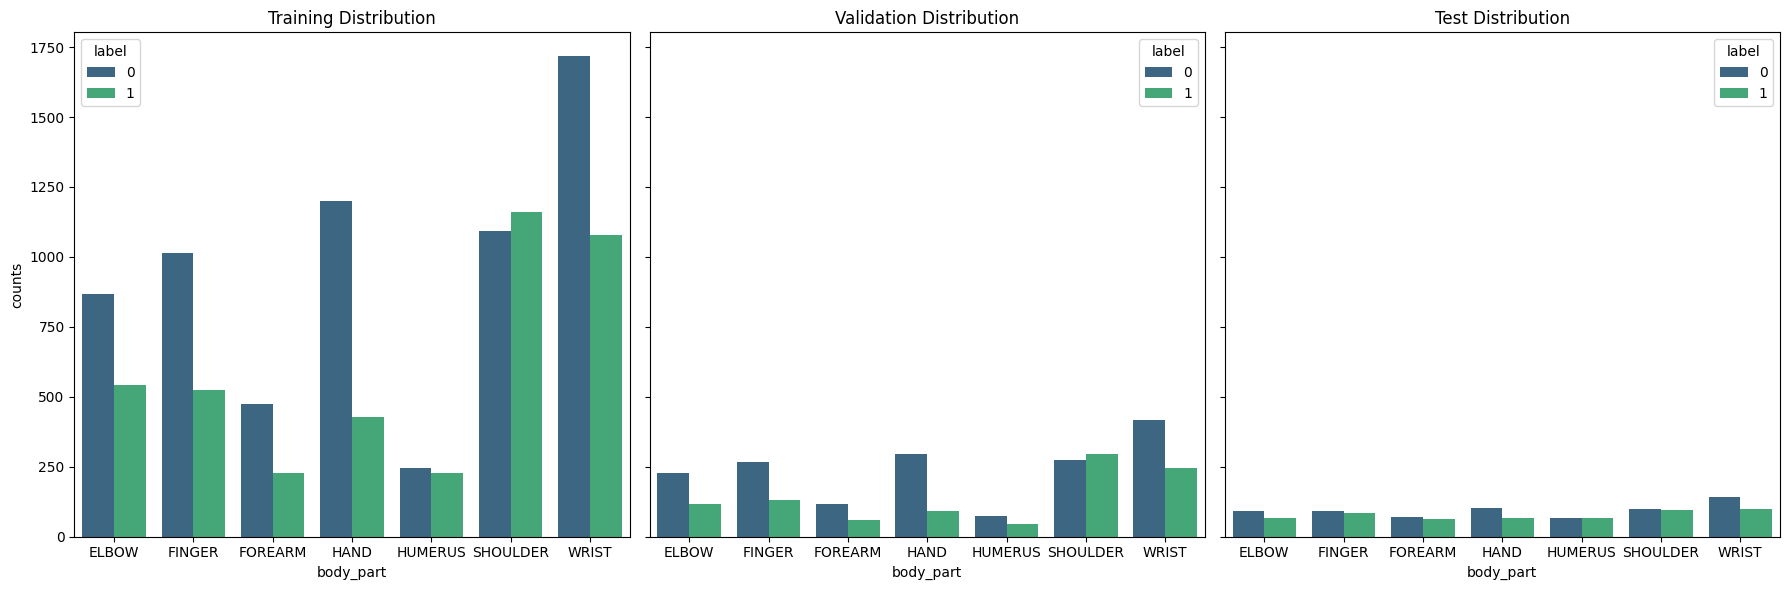

In [ ]:
# Distribution of data set by class and label
body_part_label_counts_train = train_data.groupby(['label', 'body_part']).size().reset_index(name='counts')
body_part_label_counts_val = val_data.groupby(['label', 'body_part']).size().reset_index(name='counts')
body_part_label_counts_test = test_data.groupby(['label', 'body_part']).size().reset_index(name='counts')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for training data
sns.barplot(data=body_part_label_counts_train, x='body_part', y='counts', hue='label', ax=axes[0], palette='viridis')
axes[0].set_title('Training Distribution')

# Plot for validation data
sns.barplot(data=body_part_label_counts_val, x='body_part', y='counts', hue='label', ax=axes[1], palette='viridis')
axes[1].set_title('Validation Distribution')

# Plot for test data
sns.barplot(data=body_part_label_counts_test, x='body_part', y='counts', hue='label', ax=axes[2], palette='viridis')
axes[2].set_title('Test Distribution')

fig.tight_layout()
plt.show()


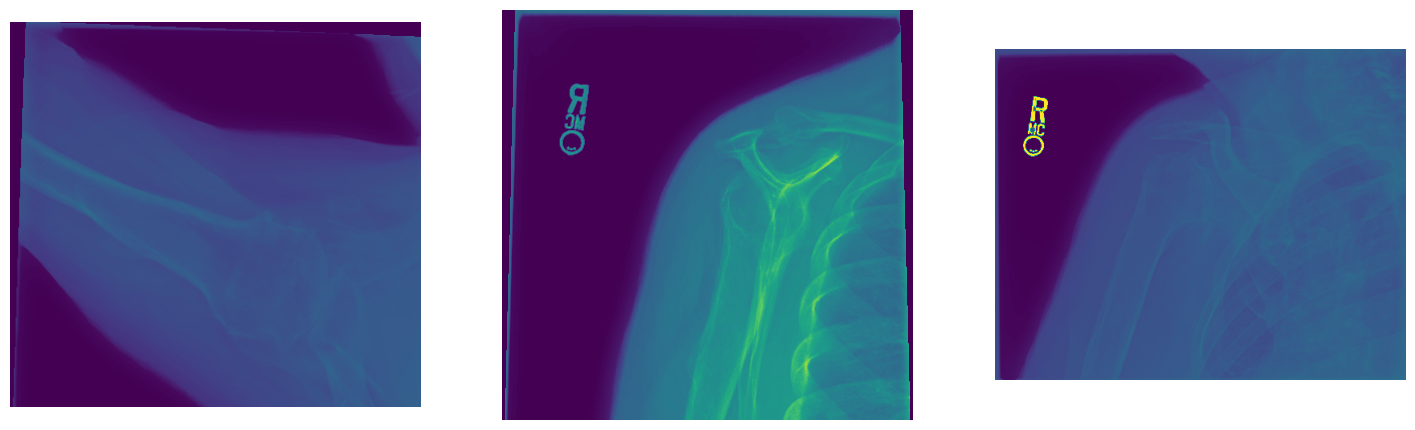

In [ ]:
# Example X-ray
image_folder = train_data['file_path'].iloc[0]  # First patient
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

# Plot
fig, axes = plt.subplots(1, len(image_files), figsize=(18, 6), sharey=True)

for i, img_path in enumerate(image_files):
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

### 2. Create Data Set and Data Loaders

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import PIL.Image as Image
from torch.utils.data import DataLoader
import torch
from torchvision.datasets.folder import pil_loader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
import re

In [ ]:
class MuraDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame containing file paths and labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_folder = self.df.iloc[idx]['file_path']
        image_paths = []
        # Prevent .img error
        for file in os.listdir(image_folder):
          if re.match(r'image\d+\.png$', file.lower()):
            image_paths.append(os.path.join(image_folder, file))
        images = [Image.open(image_path).convert('L') for image_path in image_paths]  #Should we do Grayscale 'L' or 'LA' ?

        if self.transform:
            images = [self.transform(image) for image in images]

        label = self.df.iloc[idx]['label']
        #label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)

        return images, label

# Define transformations
train_transform = transforms.Compose([
        transforms.Resize(224),
         transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])

val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])

# Dataset and DataLoader
train_dataset = MuraDataset(df=train_data, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=2, pin_memory=True, collate_fn=lambda x: zip(*x), shuffle=True)  # Collate handles diff number of images per study
first_batch = next(iter(train_loader))

In [ ]:
val_dataset = MuraDataset(df=val_data, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=2, pin_memory=True, collate_fn=lambda x: zip(*x), shuffle=False)

test_dataset = MuraDataset(df=test_data, transform=val_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=2, pin_memory=True, collate_fn=lambda x: zip(*x), shuffle=False)


first_batch = next(iter(val_loader))
first_batch = next(iter(test_loader))

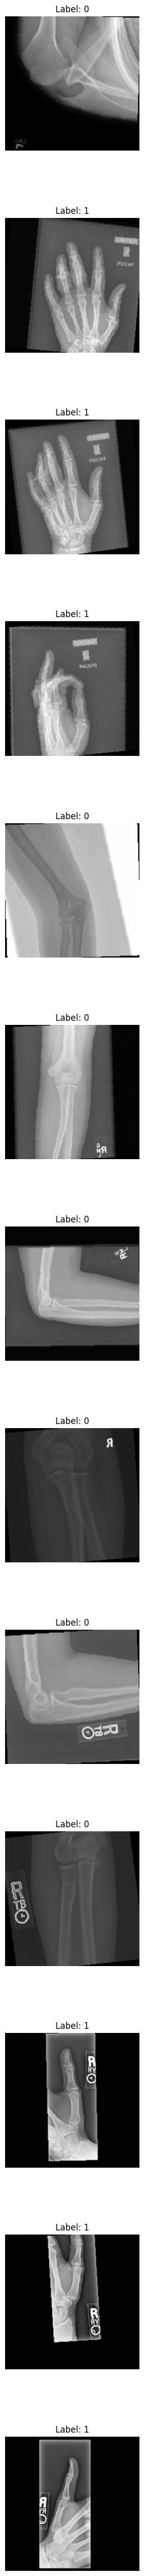

In [ ]:
def show_images(batch):
    images, labels = batch
    batch_size = len(images)

    n_rows = sum(len(imgs) for imgs in images)
    if n_rows > 1:
        fig, axes = plt.subplots(n_rows, 1, figsize=(5, n_rows * 5))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(figsize=(5, 5))
        axes = [axes]

    fig.subplots_adjust(hspace=0.5)
    current_row = 0
    for i in range(batch_size):
        for img in images[i]:
            ax = axes[current_row]
            luminance_channel = img[0, :, :]
            ax.imshow(luminance_channel, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Label: {labels[i]}')
            current_row += 1
    plt.show()

first_batch = next(iter(train_loader))
# Uncomment to show images from one batch
show_images(first_batch)


In [ ]:
first_batch = next(iter(train_loader))
images, label = first_batch

### 3. Define Model

In [ ]:
from torchvision.models import resnet18

class MultiViewCNN(nn.Module):
    def __init__(self):
        super(MultiViewCNN, self).__init__()
        # Initialize with ResNet Architecture
        self.base_model = resnet18(weights=None)
        # Modify the first convolutional layer to accept single-channel (grayscale) input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2, bias=False)
        # Modify the final fully connected layer to output a single probability value
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

    def forward(self, x):
        batch_probabilities = []
        for views in x:
            # Compute the probability for each view
            view_probabilities = [torch.sigmoid(self.base_model(view.unsqueeze(0))) for view in views]
            view_probabilities = torch.cat(view_probabilities, dim=0)
            # Calculate the mean probability across all views in a study to get single study probability
            study_probability = torch.mean(view_probabilities, dim=0, keepdim=True)
            batch_probabilities.append(study_probability)

        batch_probabilities = torch.cat(batch_probabilities, dim=0)
        return batch_probabilities

### Train Model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            images, labels = data
            # Move data to device
            labels = torch.tensor(labels).to(device)
            image_batches = [[img.to(device) for img in view] for view in images]

            optimizer.zero_grad()
            outputs = model(image_batches)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(labels)

        train_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                image_batches = [[img.to(device) for img in view] for view in images]
                labels = torch.tensor(labels).to(device)

                outputs = model(image_batches)
                val_loss = criterion(outputs, labels.float().unsqueeze(1))
                running_val_loss += val_loss.item() * len(labels)

                predicted = outputs.round()
                total += labels.size(0)
                correct += (predicted == labels.float().unsqueeze(1)).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')


In [ ]:
# Train the model
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1/2, Train Loss: 0.6770
Epoch 1/2, Validation Loss: 0.7618, Accuracy: 60.63%
Epoch 2/2, Train Loss: 0.6592
Epoch 2/2, Validation Loss: 0.9448, Accuracy: 63.38%
Finished Training


In [ ]:
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Train Loss: 0.6757
Epoch 1/2, Validation Loss: 0.6725, Accuracy: 62.82%


In [ ]:
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.6673
Epoch 1/10, Validation Loss: 0.8952, Accuracy: 52.69%
Epoch 2/10, Train Loss: 0.6448
Epoch 2/10, Validation Loss: 0.9228, Accuracy: 53.26%
Epoch 3/10, Train Loss: 0.6351
Epoch 3/10, Validation Loss: 0.7490, Accuracy: 57.36%
Epoch 4/10, Train Loss: 0.6303
Epoch 4/10, Validation Loss: 0.8859, Accuracy: 60.48%
Epoch 5/10, Train Loss: 0.6283
Epoch 5/10, Validation Loss: 0.6707, Accuracy: 60.26%
Epoch 6/10, Train Loss: 0.6229
Epoch 6/10, Validation Loss: 0.7831, Accuracy: 62.18%
Epoch 7/10, Train Loss: 0.6213
Epoch 7/10, Validation Loss: 0.9229, Accuracy: 63.53%
Epoch 8/10, Train Loss: 0.6138
Epoch 8/10, Validation Loss: 0.7263, Accuracy: 62.55%
Epoch 9/10, Train Loss: 0.6078
Epoch 9/10, Validation Loss: 0.8163, Accuracy: 63.15%
Epoch 10/10, Train Loss: 0.5874
Epoch 10/10, Validation Loss: 4.8177, Accuracy: 48.66%
Finished Training


### Experiments

We experimented with various learning rates, padding sizes, strides, kernal sizes, and batch sizes as well as different weight initializations

Due to computing power issues, these are scattered in different notebooks, so the following table summarizes our findings


#### initial experiments for model parameters trained on 1 epoch

In [8]:
import pandas as pd
df = pd.DataFrame(columns=['Learning Rate', 'Kernal Size', 'Stride', 'Padding', 'Validation Loss','Accuracy' ])
df['Learning Rate'] = ['0.1', '0.01', '0.001', '0.001', '0.001']
df['Kernal Size'] = ['7', '7', '7', '3', '3']
df['Stride'] = ['2','2','2','1','1']
df['Padding'] = ['3', '3','3', '3', '2']
df['Validation Loss'] = ['37.1848', '0.7355', '0.6787','1.1189','0.9187']
df['Accuracy'] = ['62.82', '58.19', '59.80','60.48', '63.04']
df

,Learning Rate,Kernal Size,Stride,Padding,Validation Loss,Accuracy
0,0.1,7,2,3,37.1848,62.82
1,0.01,7,2,3,0.7355,58.19
2,0.001,7,2,3,0.6787,59.80
3,0.001,3,1,3,1.1189,60.48
4,0.001,3,1,2,0.9187,63.04


#### next experiments with batch size, and weight initialization, tested on the testing data to see which had best recall, precision and accuracy

In [5]:
df = pd.DataFrame(columns=['Learning Rate', 'Kernal Size', 'Stride', 'Padding','Batch', 'Epochs', 'Weights' ,'Test Accuracy', 'Precision', 'Recall' ])
df['Learning Rate'] = ['0.001', '0.001']
df['Kernal Size'] = ['7', '3']
df['Stride'] = ['2','1']
df['Padding'] = ['3', '2']
df['Batch'] = ['5', '5']
df['Epochs'] = ['2', '5']
df['Weights'] = ['untrained', 'untrained']
df['Test Accuracy'] = ['0.57', '0.53']
df['Precision'] = ['0.593', '0.48']
df['Recall'] = ['0.165', '0.71']
df

,Learning Rate,Kernal Size,Stride,Padding,Batch,Epochs,Weights,Test Accuracy,Precision,Recall
0,0.001,7,2,3,5,2,untrained,0.57,0.593,0.165
1,0.001,3,1,2,5,5,untrained,0.53,0.48,0.71


From this we found the best parameters were:
* learning rate = 0.001
* kernal size = 3
* stride = 1
* padding = 2

The experiments after will all have these parameters.

In [7]:
df = pd.DataFrame(columns=['Batch', 'Epochs','Weights', 'Test Accuracy', 'Precision', 'Recall'])
df['Batch'] = ['5','10', '32', '5', '32']
df['Epochs'] = ['5', '5', '10', '5', '10']
df['Weights'] = ['untrained', 'untrained','untrained', 'resnet default','resnet default']
df['Test Accuracy'] = ['0.53', '0.48', '0.53','0.55','0.46']
df['Precision'] = ['0.48', '0.387', '0.48', '0.0','0.43']
df['Recall'] = ['0.71', '0.286','0.78', '0.0', '0.64']
df

,Batch,Epochs,Weights,Test Accuracy,Precision,Recall
0,5,5,untrained,0.53,0.48,0.71
1,10,5,untrained,0.48,0.387,0.286
2,32,10,untrained,0.53,0.48,0.78
3,5,5,resnet default,0.55,0.0,0.0
4,32,10,resnet default,0.46,0.43,0.64


Our best model had the following parameters and settings:
* learning rate = 0.001
* kernal size = 3
* stride = 1
* padding = 2
* batch size = 32
* epochs = 10
* weights = untrained

Further evaluation of this model with more visualizations are below.
We chose this because, although some had a higher accuracy, this model had a close to highest accuracy, and preformed well on the recall metric, which is considered most important with medical data.

### Evaluating Model

In [ ]:
# Testing phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
running_test_loss = 0.0
correct = 0
total = 0
y_hat = []
y = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Track y values
        y.extend(list(labels))
        image_batches = [[img.to(device) for img in view] for view in images]
        labels = torch.tensor(labels).to(device)

        outputs = model(image_batches)
        test_loss = criterion(outputs, labels.float().unsqueeze(1))
        running_test_loss += test_loss.item() * len(labels)

        # Track probability outputs
        y_hat.extend([output for output_list in outputs.tolist() for output in output_list])
        predicted = outputs.round()
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Test Loss: 4.5378, Accuracy: 52.54%


In [ ]:
test_data['y_hat_prob'] = y_hat
test_data['y_hat'] = round(test_data['y_hat_prob'])
test_data

,file_path,label,body_part,patient_id,study_type,y_hat_prob,y_hat
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,11185,study1,0.927536,1.0
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,11186,study1,0.812522,1.0
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,11186,study2,0.879336,1.0
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,11186,study3,0.934619,1.0
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,11187,study1,0.004165,0.0
...,...,...,...,...,...,...,...
1194,MURA-v1.1/valid/XR_FINGER/patient11965/study1_...,0,FINGER,11965,study1,1.000000,1.0
1195,MURA-v1.1/valid/XR_FINGER/patient11855/study1_...,0,FINGER,11855,study1,0.006998,0.0
1196,MURA-v1.1/valid/XR_FINGER/patient11966/study1_...,0,FINGER,11966,study1,0.999995,1.0
1197,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,0,FINGER,11967,study1,0.352036,0.0


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
y = test_data['label'].values
y_hat = test_data['y_hat'].values
y_hat_prob = test_data['y_hat_prob'].values

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y, y_hat)
precision = precision_score(y, y_hat)
recall = recall_score(y, y_hat)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5254378648874062
Precision: 0.48220436280137774
Recall: 0.7806691449814126


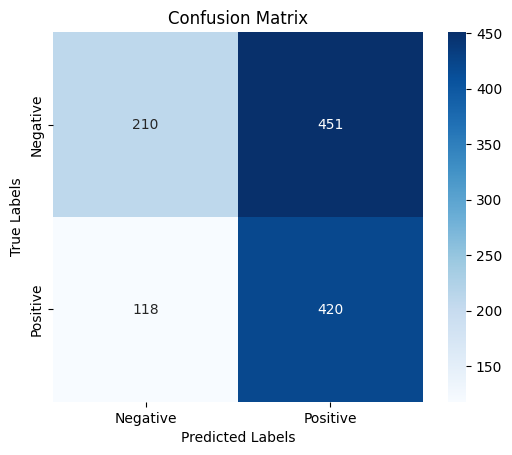

In [ ]:
# Confusion Matric
cm = confusion_matrix(y, y_hat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

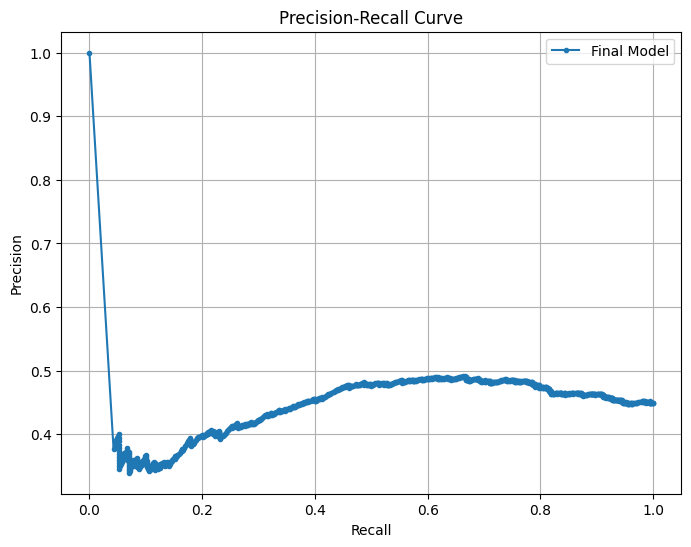

In [ ]:
# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y, y_hat_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Final Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

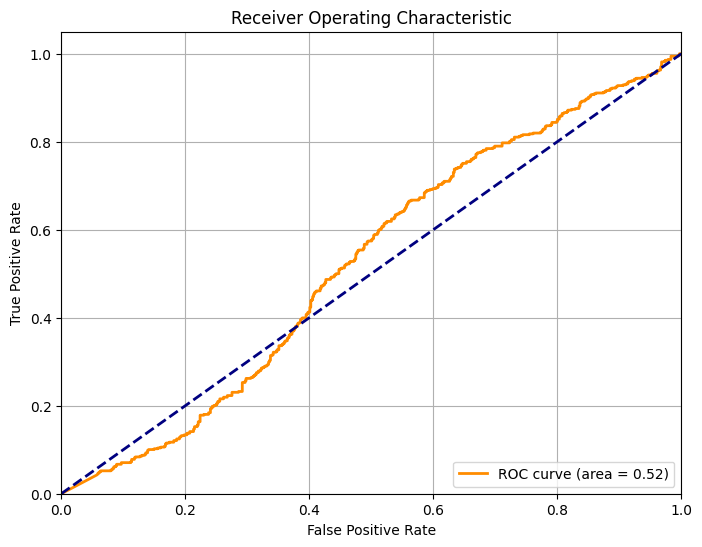

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y, y_hat_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

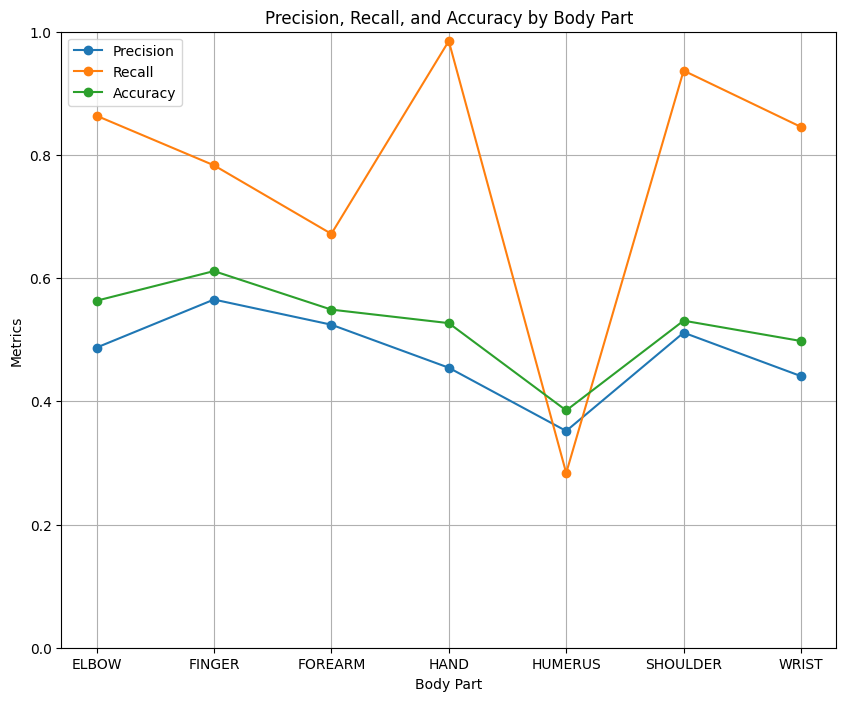

In [ ]:
# Metrics by body part

metrics = pd.DataFrame(columns=['body_part', 'precision', 'recall', 'accuracy'])
grouped = test_data.groupby('body_part')

metrics_list = []
for name, group in grouped:
    precision = precision_score(group['label'], group['y_hat'])
    recall = recall_score(group['label'], group['y_hat'])
    accuracy = accuracy_score(group['label'], group['y_hat'])
    metrics_list.append({'body_part': name, 'precision': precision, 'recall': recall, 'accuracy': accuracy})

metrics = pd.DataFrame(metrics_list)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(metrics['body_part'], metrics['precision'], label='Precision', marker='o')
plt.plot(metrics['body_part'], metrics['recall'], label='Recall', marker='o')
plt.plot(metrics['body_part'], metrics['accuracy'], label='Accuracy', marker='o')
plt.xlabel('Body Part')
plt.ylabel('Metrics')
plt.ylim([0,1])
plt.title('Precision, Recall, and Accuracy by Body Part')
plt.legend()
plt.grid(True)
plt.show()

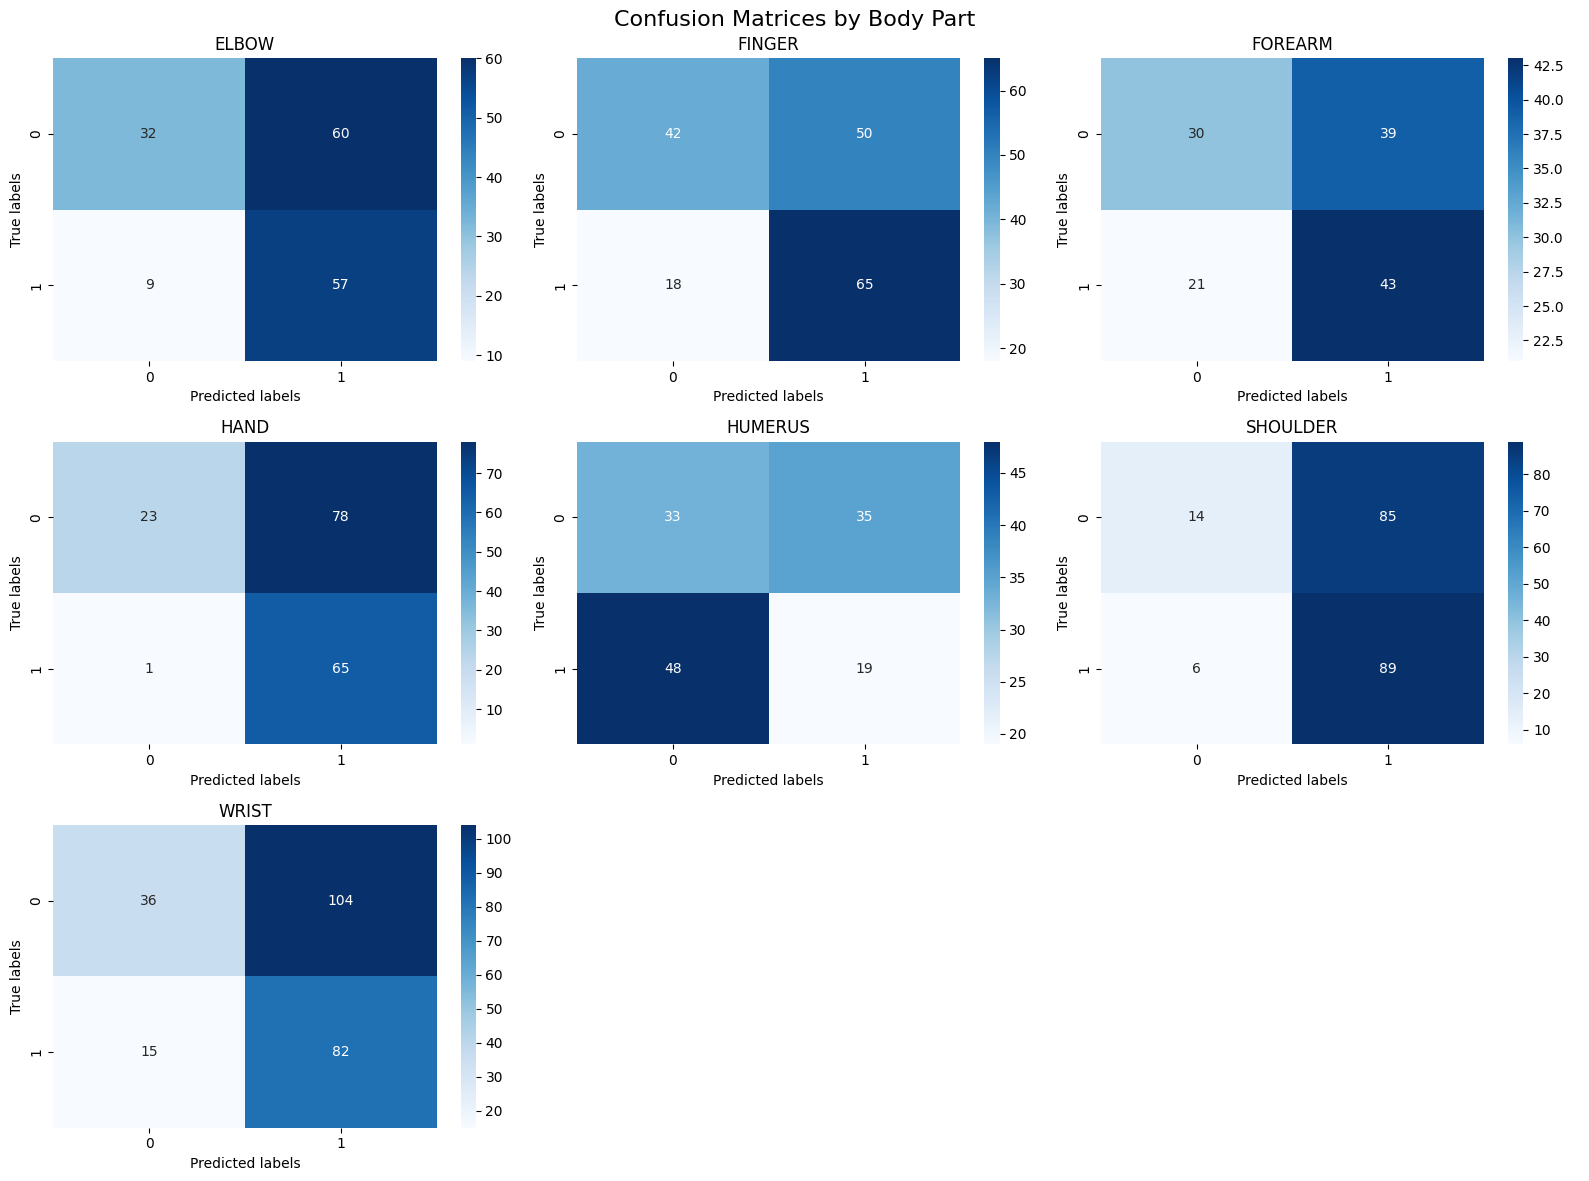

In [ ]:
# Confusion Matrices by Body Part
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle('Confusion Matrices by Body Part', fontsize=16)
axes = axes.flatten()

for idx, (name, group) in enumerate(grouped):
    cm = confusion_matrix(group['label'], group['y_hat'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted labels')
    axes[idx].set_ylabel('True labels')

# Hide any unused subplots
for ax in axes[len(grouped):]:
    ax.axis('off')

plt.tight_layout()
plt.show()